#Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


#Unzip Data

In [2]:
#Use bash command to unzip data files
!unzip -q /content/gdrive/MyDrive/Data.zip

#Load Data

In [8]:
#Get pandas package
import pandas as pd

#Read benign and malignant packets
df_benign = pd.read_csv('benign.csv')
df_malign = pd.read_csv('malign.csv')

#Data preprocessing

##Cleaning

In [9]:
#Important features
ft_cols = ['frame.time_relative', 'frame.time_delta_displayed', 'frame.time_delta',
       'tcp.time_relative', 'tcp.time_delta', 'iec60870_104.apdulen',
       'iec60870_104.tx', 'iec60870_104.rx',
       'iec60870_asdu.typeid', 'iec60870_asdu.sq', 'iec60870_asdu.numix',
       'iec60870_asdu.causetx', 'iec60870_asdu.nega', 'iec60870_asdu.test',
       'iec60870_asdu.oa', 'iec60870_asdu.addr', 'iec60870_asdu.ioa',
       'iec60870_asdu.bcr.count', 'iec60870_asdu.bcr.sq',
       'iec60870_asdu.bcr.cy', 'iec60870_asdu.bcr.ca', 'iec60870_asdu.bcr.iv']

#Select important features in each dataframe
df_benign = df_benign[ft_cols]
df_malign = df_malign[ft_cols]

##Normalization

In [10]:
#Get standard scaler from sklearn
from sklearn.preprocessing import StandardScaler

#Fit standard scaler to data
scaler = StandardScaler()
scaler.fit(df_benign)

#Normalize both packets
df_benign_scaled = scaler.transform(df_benign)
df_malign_scaled = scaler.transform(df_malign)

##Prepare training and testing datasets

In [11]:
#Get numpy and train test split packages
import numpy as np
from sklearn.model_selection import train_test_split

#Target labels
Labels = ["Benign", "Malignant"]

#Separate training and testing sets from the original packets
X_train, X_test_benign = train_test_split(df_benign_scaled, test_size=0.001, random_state=9)
_, X_test_malign = train_test_split(df_malign_scaled, test_size=0.02, random_state=9)

#Prepare the test set
X_test = np.concatenate((X_test_benign, X_test_malign), axis=0)
Y_test = np.concatenate((np.zeros(len(X_test_benign)),np.ones(len(X_test_malign))),axis=0)

#Autoencoder model design

In [12]:
#Get tensorflow package
import tensorflow as tf

#Input shape of the data
input_shape = len(df_benign.columns)

#Design model
def Autoencoder():
  # Create input layer
  inputs = tf.keras.layers.Input(shape=(input_shape,))

  #Encoder model layers
  encoder = tf.keras.layers.Dense(units=32, activation="relu")(inputs)
  encoder = tf.keras.layers.Dense(units=16, activation="relu")(encoder)
  encoder = tf.keras.layers.Dense(units=8,  activation="relu")(encoder)

  #Decoder model layers
  decoder = tf.keras.layers.Dense(units=16,  activation="relu")(encoder)
  decoder = tf.keras.layers.Dense(units=32, activation="relu")(decoder)
  decoder = tf.keras.layers.Dense(units=input_shape)(decoder)

  #Create the model
  model = tf.keras.Model(inputs=inputs, outputs=decoder)
  return model

#Get autoencoder model
Autoencoder = Autoencoder()

#Compile the model with loss and optimizer
Autoencoder.compile(optimizer=tf.keras.optimizers.Adam(),
                               loss="mse")

#Model training

In [ ]:
#Number of iterations
Epochs = 10

#Fit the model to the training data
model_history = Autoencoder.fit(X_train, X_train, epochs=Epochs)

Epoch 1/10
139255/139255 [==============================] - 371s 3ms/step - loss: 7.6321e-04
Epoch 2/10
139255/139255 [==============================] - 361s 3ms/step - loss: 4.7097e-05
Epoch 3/10
139255/139255 [==============================] - 369s 3ms/step - loss: 3.4333e-05
Epoch 4/10
139255/139255 [==============================] - 360s 3ms/step - loss: 2.9470e-05
Epoch 5/10
139255/139255 [==============================] - 361s 3ms/step - loss: 2.7156e-05
Epoch 6/10
139255/139255 [==============================] - 359s 3ms/step - loss: 2.4103e-05
Epoch 7/10
139255/139255 [==============================] - 357s 3ms/step - loss: 2.2261e-05
Epoch 8/10
139255/139255 [==============================] - 358s 3ms/step - loss: 2.0036e-05
Epoch 9/10
139255/139255 [==============================] - 357s 3ms/step - loss: 1.8918e-05
Epoch 10/10
139255/139255 [==============================] - 357s 3ms/step - loss: 1.7727e-05


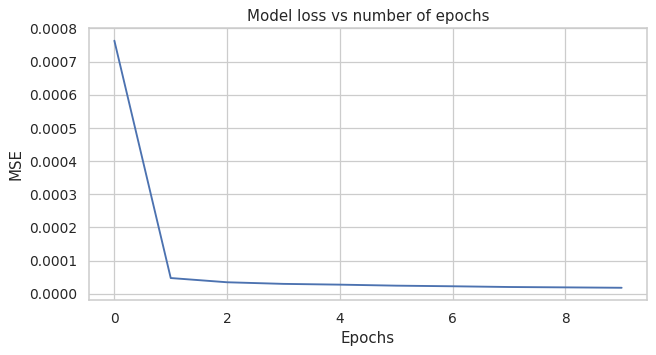

In [ ]:
#Import plotting packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')

#Plot model loss with epochs
plt.figure(figsize=(8,4),dpi=90)
plt.plot(range(Epochs), model_history.history['loss'])
plt.ylabel("MSE")
plt.xlabel("Epochs")
plt.title("Model loss vs number of epochs");

#Model Evaluation

##Test set classes

Text(0.5, 1.0, 'Test data label count')

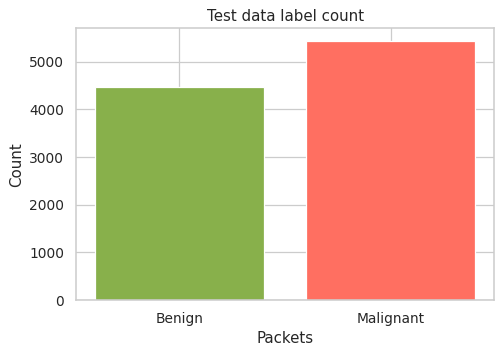

In [ ]:
#Plot the count of labels
plt.figure(figsize=(6,4),dpi=90)
plt.bar(height=[len(X_test_benign),len(X_test_malign)],x=Labels, color=['#88B04B','#FF6F61']);
plt.xlabel('Packets')
plt.ylabel('Count')
plt.title('Test data label count')

##Model Predictions

In [ ]:
#Get RMSE on the benign test set
X_pred_benign = Autoencoder.predict(X_test_benign,verbose=0)
Rmse_benign = np.sqrt(np.mean((X_pred_benign-X_test_benign)**2))

#Calculate threshold
Threshold = Rmse_benign + Rmse_benign*0.3

#Get model predictions on test data
X_pred = Autoencoder.predict(X_test,verbose=0)

#Calculate RMSE error for test sets
benign_err = np.sqrt(np.mean((Autoencoder.predict(X_test_benign,verbose=0)-X_test_benign)**2, axis=1))
malig_err =np.sqrt(np.mean((Autoencoder.predict(X_test_malign,verbose=0)-X_test_malign)**2, axis=1))
Rmse_err = np.sqrt(np.mean((X_pred-X_test)**2, axis=1))

#Convert errors to labels
Pred_labels = (Rmse_err>Threshold).astype(int)

##RMSE Distribution

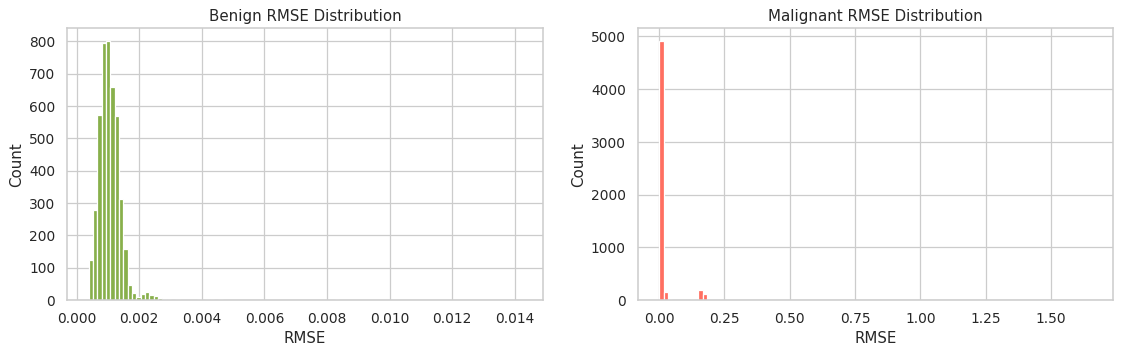

In [ ]:
#Plot RMSE
plt.figure(figsize=(15,4),dpi=90)
plt.subplot(1,2,1)
plt.hist(benign_err,bins=100, color='#88B04B');
plt.xlabel('RMSE')
plt.ylabel('Count')
plt.title('Benign RMSE Distribution')
plt.subplot(1,2,2)
plt.hist(malig_err,bins=100, color='#FF6F61', label='Fair');
plt.xlabel('RMSE')
plt.ylabel('Count')
plt.title('Malignant RMSE Distribution')
plt.show()

##Classification report

In [ ]:
#Get evaluation metrics packages
from sklearn.metrics import classification_report, confusion_matrix

#Print classification report
print(classification_report(Y_test, Pred_labels,target_names=Labels))

              precision    recall  f1-score   support

      Benign       0.65      0.94      0.77      4461
   Malignant       0.92      0.59      0.72      5426

    accuracy                           0.75      9887
   macro avg       0.79      0.77      0.75      9887
weighted avg       0.80      0.75      0.74      9887



##Confusion matrix

Text(0.5, 66.25, 'Predictions')

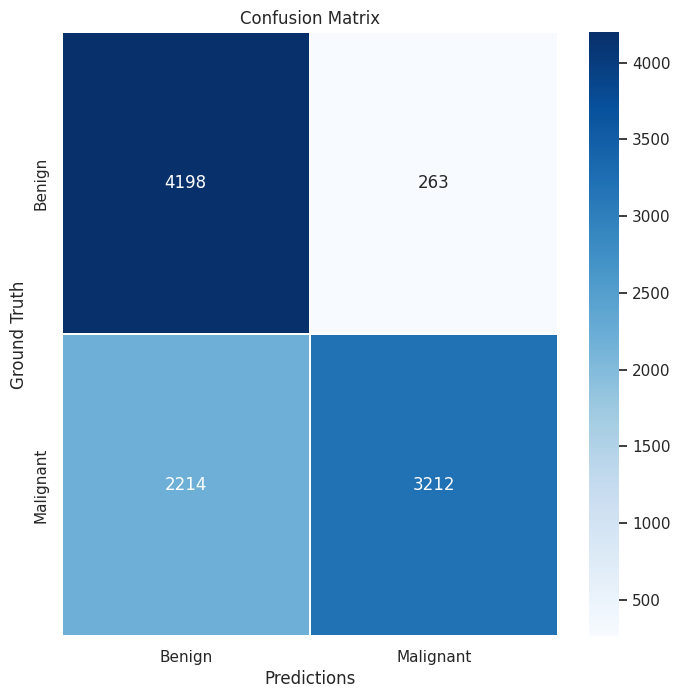

In [ ]:
#Calculate confusion matrix
matrix = confusion_matrix(Y_test, Pred_labels)

#Plot confusion matrix
plt.figure(figsize=(8, 8),dpi=100)
sns.heatmap(matrix,
            cmap='Blues',
            linecolor='white',
            linewidths=1,
            xticklabels=Labels,
            yticklabels=Labels,
            annot=True,
            fmt='d')

#Label the plot
plt.title('Confusion Matrix')
plt.ylabel('Ground Truth')
plt.xlabel('Predictions')